In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import matplotlib.pylab as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(16.7,8.27)})

In [103]:
LOOKBACK = 2

In [104]:
def series_to_supervised(sequence, lookback, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + lookback
        if end_ix > len(sequence) - 1:
            break

        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [105]:
df_0 = pd.read_csv("7hnz0037.csv")
df_0 = df_0[['loc. (actual) [km]', 'voltage [V]']]
df_0 = df_0.set_index('loc. (actual) [km]')
df_0.sort_index(inplace=True)


In [106]:
scaler = MinMaxScaler()

In [107]:
df_scaled = scaler.fit_transform(df_0)

In [108]:
X, y = series_to_supervised(df_scaled, LOOKBACK, 1)

In [109]:
inputs = Input(shape=X.shape[1:])
x = Flatten()(inputs)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(LOOKBACK, activation='relu')(x)
x = Dropout(0.2)(x)
out = Dense(1)(x)

model = Model(inputs, out)
model.compile(loss='mse', optimizer='adam')
model.fit(X, y, epochs=10, validation_split=0.1)

Train on 900 samples, validate on 100 samples
Epoch 1/10
900/900 [==============================] - 1s 1ms/step - loss: 0.0541 - val_loss: 0.0267
Epoch 2/10
900/900 [==============================] - 0s 44us/step - loss: 0.0301 - val_loss: 0.0232
Epoch 3/10
900/900 [==============================] - 0s 42us/step - loss: 0.0227 - val_loss: 0.0239
Epoch 4/10
900/900 [==============================] - 0s 44us/step - loss: 0.0242 - val_loss: 0.0277
Epoch 5/10
900/900 [==============================] - 0s 44us/step - loss: 0.0208 - val_loss: 0.0244
Epoch 6/10
900/900 [==============================] - 0s 44us/step - loss: 0.0200 - val_loss: 0.0240
Epoch 7/10
900/900 [==============================] - 0s 42us/step - loss: 0.0201 - val_loss: 0.0220
Epoch 8/10
900/900 [==============================] - 0s 43us/step - loss: 0.0174 - val_loss: 0.0229
Epoch 9/10
900/900 [==============================] - 0s 42us/step - loss: 0.0180 - val_loss: 0.0218
Epoch 10/10
900/900 [=========================

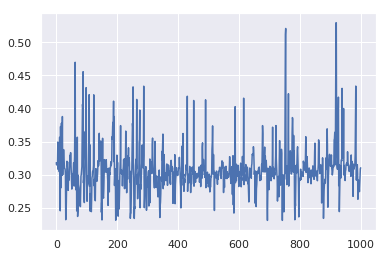

In [110]:
yhat = model.predict(X)
plt.plot(yhat)
#plt.plot(y)

In [111]:
df_test = pd.read_csv("7hnz0037E1.csv")
df_test = df_test[['loc. (actual) [km]', 'voltage [V]']]
df_test = df_test.set_index('loc. (actual) [km]')
df_test.sort_index(inplace=True)


In [112]:
df_test_scaled = scaler.fit_transform(df_test)
X_test, y_test = series_to_supervised(df_test_scaled, LOOKBACK, 1)

In [113]:
diff=[]
ratio=[]
p = model.predict(X_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

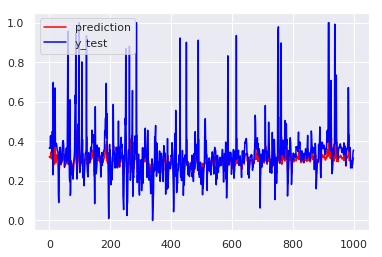

In [114]:
# plot the prediction and the reality (for the test data)
fig, axs = plt.subplots()
axs.plot(p,color='red', label='prediction')
axs.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()

In [117]:
# select the most distant prediction/reality data points as anomalies
diff = pd.Series(diff).astype(float)
number_of_outliers = int(0.01*len(diff))
threshold = diff.nlargest(number_of_outliers).min()
# data with anomaly label (test data part)
test = (diff >= threshold).astype(int)
# the training data part where we didn't predict anything (overfitting possible): no anomaly
#complement = pd.Series(0, index=np.arange(len(df)-testdatasize))
# # add the data to the main
#df['anomaly27'] = complement.append(test, ignore_index='True')
#print(df_test['anomaly27'].value_counts())

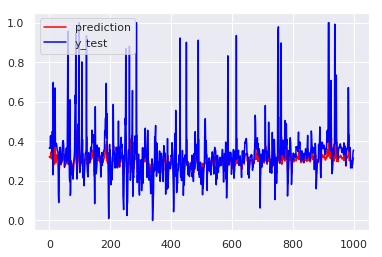

In [118]:
# plot the prediction and the reality (for the test data)
fig, axs = plt.subplots()
axs.plot(p,color='red', label='prediction')
axs.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()

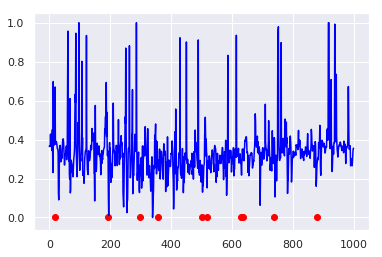

In [119]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = diff.nsmallest(10)

ax.plot(y_test, color='blue')
ax.scatter(a.index, a, color='red')
plt.show()